In [1]:
import pandas as pd

data = pd.read_csv('data/^NDX_raw_data.csv')
data.rename(columns={'Date': 'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'}, inplace=True)

data_backup = data.iloc[3524:]

data = data.iloc[:3524]
data_copy = data.copy()

In [2]:
data

,date,open,high,low,close,volume
0,2004-01-02 00:00:00-05:00,1474.160034,1479.589966,1458.510010,1463.569946,1666780000
1,2004-01-05 00:00:00-05:00,1474.550049,1496.579956,1474.189941,1496.579956,2362910000
2,2004-01-06 00:00:00-05:00,1492.410034,1504.469971,1486.589966,1501.260010,2273220000
3,2004-01-07 00:00:00-05:00,1498.380005,1514.449951,1491.199951,1514.260010,2294280000
4,2004-01-08 00:00:00-05:00,1524.060059,1530.650024,1513.339966,1530.650024,2683950000
...,...,...,...,...,...,...
3519,2017-12-22 00:00:00-05:00,6462.549805,6467.830078,6449.000000,6465.169922,1541880000
3520,2017-12-26 00:00:00-05:00,6427.319824,6438.240234,6407.990234,6433.160156,1301000000
3521,2017-12-27 00:00:00-05:00,6437.060059,6448.939941,6425.919922,6435.149902,1411010000
3522,2017-12-28 00:00:00-05:00,6449.529785,6452.069824,6432.680176,6441.419922,1319870000


#### slice the data:

In [3]:
import numpy as np

# Create input sequences and targets
def create_sequences(features, target, seq_length):
    X_seq = []
    y_seq = []
    for i in range(len(features) - seq_length):
        X_seq.append(features[i:i+seq_length])  # Input sequence
        y_seq.append(target[i+seq_length]) # Target value (next data point)
    return np.array(X_seq), np.array(y_seq)

In [4]:
import numpy as np

## Creating sequences
def create_dataset(dataset, time_step=1, output_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-output_step):
        a = dataset[i:(i+time_step), 0]
        b = dataset[(i+time_step):(i+time_step)+output_step, 0]
        dataX.append(a)
        dataY.append(b)

    return np.array(dataX), np.array(dataY)

In [5]:
period = 60
output_step = 7

In [6]:
X, y = create_dataset(data[['close']].to_numpy(), time_step=period, output_step=output_step)

In [7]:
X.shape, y.shape

((3457, 60), (3457, 7))

In [8]:
X[0],y[0]

(array([1463.56994629, 1496.57995605, 1501.26000977, 1514.26000977,
        1530.65002441, 1520.45996094, 1539.77001953, 1524.7800293 ,
        1534.07995605, 1532.01000977, 1553.61999512, 1552.86999512,
        1546.59997559, 1530.42004395, 1531.20996094, 1553.66003418,
        1519.22998047, 1491.56994629, 1496.40002441, 1493.07995605,
        1487.83996582, 1491.84997559, 1462.60998535, 1465.0300293 ,
        1498.94995117, 1490.91003418, 1500.29003906, 1514.18005371,
        1501.33996582, 1484.4699707 , 1506.56994629, 1507.48999023,
        1484.80004883, 1482.09997559, 1463.75      , 1462.05004883,
        1470.2199707 , 1477.13000488, 1470.38000488, 1489.48999023,
        1473.2199707 , 1466.08996582, 1481.35998535, 1472.98999023,
        1441.11999512, 1437.4699707 , 1417.5       , 1402.19995117,
        1431.40002441, 1399.86999512, 1407.06994629, 1428.89001465,
        1417.77001953, 1398.57995605, 1381.39001465, 1370.04003906,
        1381.85998535, 1425.85998535, 1415.39001

In [9]:
data_input = np.array([np.concatenate((X[i], y[i]), axis=0) for i in range(X.shape[0])])

In [10]:
data_input, data_input.shape

(array([[1463.56994629, 1496.57995605, 1501.26000977, ..., 1508.36999512,
         1493.57995605, 1481.95996094],
        [1496.57995605, 1501.26000977, 1514.26000977, ..., 1493.57995605,
         1481.95996094, 1485.51000977],
        [1501.26000977, 1514.26000977, 1530.65002441, ..., 1481.95996094,
         1485.51000977, 1495.93005371],
        ...,
        [5934.91015625, 5932.31982422, 5867.35009766, ..., 6472.68994141,
         6465.16992188, 6433.16015625],
        [5932.31982422, 5867.35009766, 5881.33984375, ..., 6465.16992188,
         6433.16015625, 6435.14990234],
        [5867.35009766, 5881.33984375, 5937.79003906, ..., 6433.16015625,
         6435.14990234, 6441.41992188]]),
 (3457, 67))

#### seasonal_decomposition for each slice:

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

trend_period = 14

decompositions = np.array([seasonal_decompose(data_input[i], model='additive', period=trend_period) for i in range(data_input.shape[0])])
trends = np.array([decompositions[i].trend for i in range(decompositions.shape[0])])

In [12]:
trends

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [13]:
trends[0]

array([          nan,           nan,           nan,           nan,
                 nan,           nan,           nan, 1526.76785278,
       1531.22214181, 1533.9025007 , 1533.73392596, 1531.70035226,
       1529.49928066, 1526.66677856, 1523.63606044, 1519.90748814,
       1514.96284703, 1510.6182033 , 1506.45284598, 1502.58606393,
       1500.35213797, 1498.70535278, 1495.16749355, 1492.24427577,
       1492.36070469, 1492.51499285, 1491.70856585, 1490.45606777,
       1488.53142875, 1487.73893084, 1488.44285801, 1487.85464478,
       1486.7835737 , 1485.76606968, 1483.08177839, 1480.65070452,
       1479.52713449, 1476.77963693, 1471.94142369, 1467.03713553,
       1461.77999006, 1457.77106149, 1454.39498901, 1449.91891479,
       1445.94069999, 1442.33891514, 1437.21320016, 1430.68677194,
       1423.97677612, 1416.99285017, 1411.75606428, 1409.15392194,
       1408.40785435, 1409.57178606, 1411.85607474, 1413.92857579,
       1417.93750436, 1424.78500802, 1430.71322196, 1435.31607

In [14]:
trends.shape

(3457, 67)

In [15]:
trends_dropna = list()

for trend in trends:
    trends_dropna.append(trend[~np.isnan(trend)])

trends_dropna = np.array(trends_dropna)

In [16]:
trends_dropna.shape

(3457, 53)

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = list(MinMaxScaler() for i in range(trends_dropna.shape[0]))
trends_scaled = list()

for i in range(trends_dropna.shape[0]):
    trends_scaled.append(scaler[i].fit_transform(trends_dropna[i].reshape(-1,1)))

trends_scaled = np.array(trends_scaled)

In [18]:
trends.shape, trends_dropna.shape, trends_scaled.shape

((3457, 67), (3457, 53), (3457, 53, 1))

In [19]:
trends_scaled[0], trends_scaled[0].shape

(array([[0.94314779],
        [0.97864165],
        [1.        ],
        [0.99865672],
        [0.98245225],
        [0.96491308],
        [0.94234238],
        [0.91819221],
        [0.8884812 ],
        [0.84907999],
        [0.81445983],
        [0.78126832],
        [0.75045599],
        [0.73265503],
        [0.71953267],
        [0.69134136],
        [0.66804779],
        [0.66897555],
        [0.67020499],
        [0.66377901],
        [0.65379851],
        [0.63846209],
        [0.6321471 ],
        [0.63775632],
        [0.63306916],
        [0.62453437],
        [0.61642642],
        [0.59503673],
        [0.5756648 ],
        [0.56671167],
        [0.54481832],
        [0.50626518],
        [0.46718552],
        [0.42529412],
        [0.39334911],
        [0.36644698],
        [0.33077953],
        [0.29907926],
        [0.27037855],
        [0.22953446],
        [0.17752883],
        [0.12406045],
        [0.06840926],
        [0.0266801 ],
        [0.00594502],
        [0

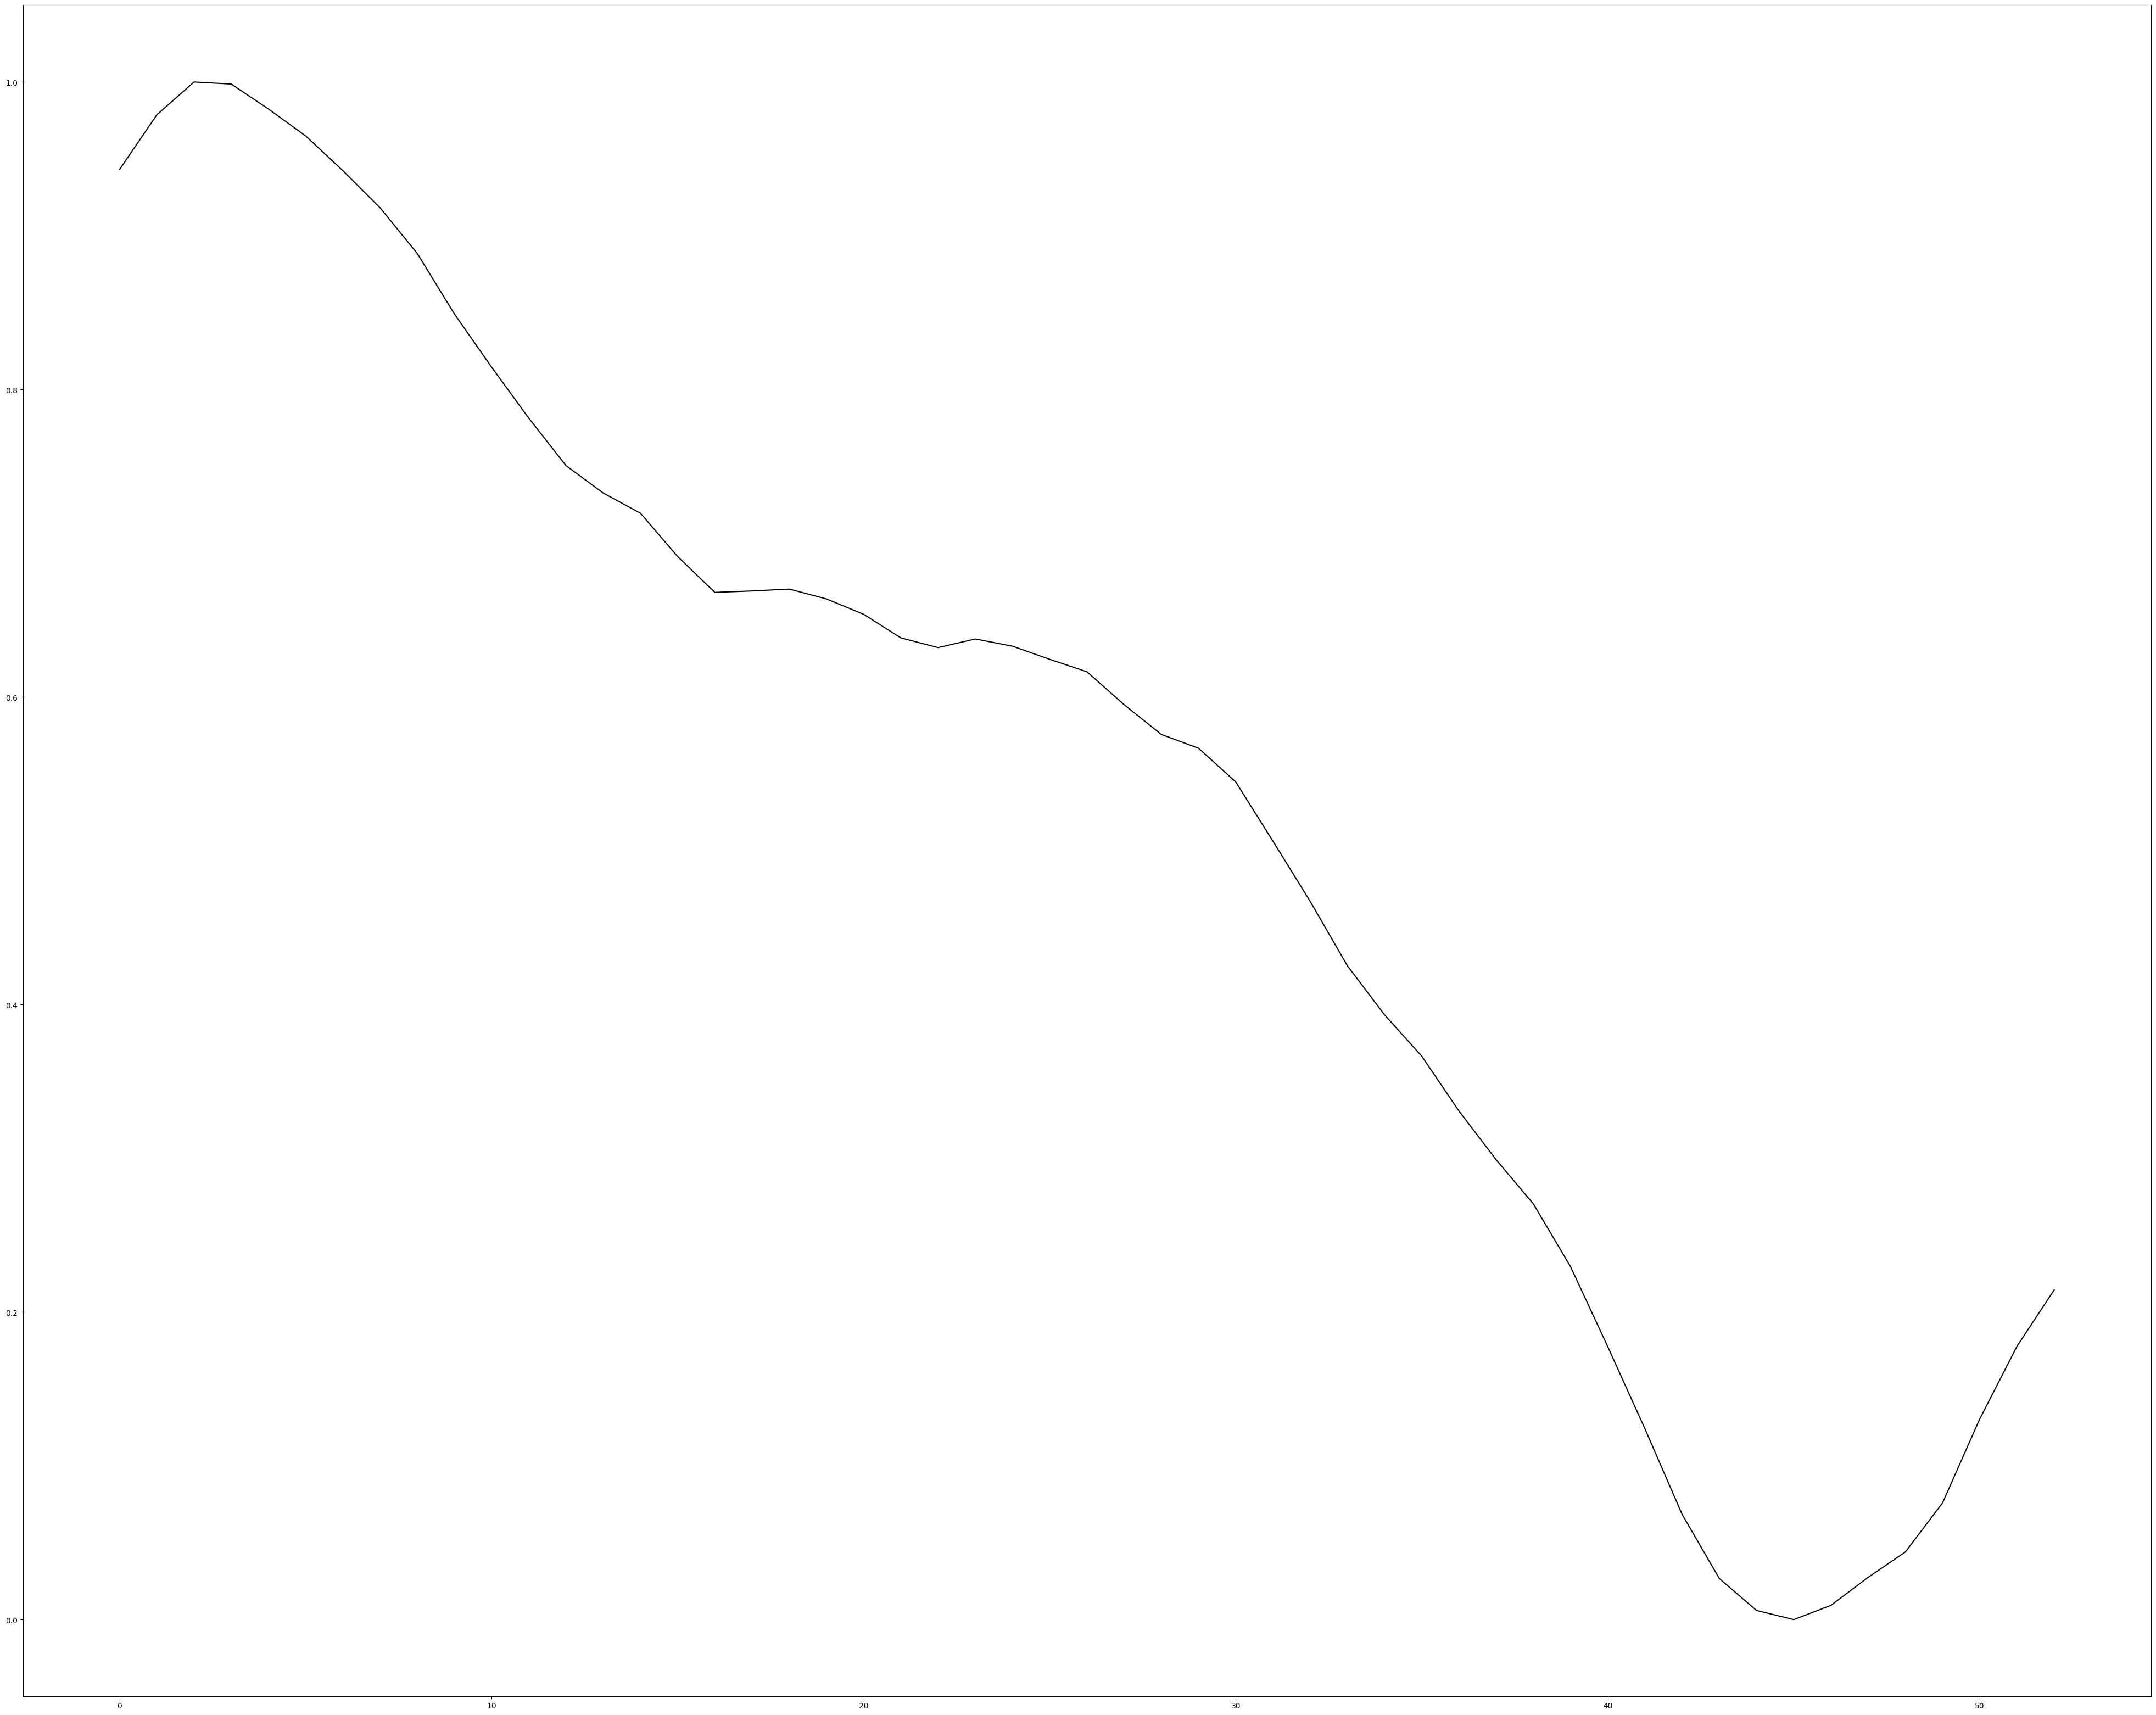

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))

plt.plot(trends_scaled[0], color='black')

In [21]:
X_input = list()
y_input = list()

for trend in trends_scaled:
    X_input.append(trend[:trend.shape[0]-7])
    y_input.append(trend[trend.shape[0]-7:])

X_input = np.array(X_input)
y_input = np.array(y_input)

In [22]:
X_input.shape, y_input.shape

((3457, 46, 1), (3457, 7, 1))

In [23]:
num_features = trends_scaled.shape[2]
input_period = X_input.shape[1]
output_step = y_input.shape[1]
units = 128

In [24]:
y_input

array([[[0.00927475],
        [0.02747703],
        [0.04399169],
        ...,
        [0.13050082],
        [0.17773959],
        [0.21441728]],

       [[0.02747703],
        [0.04399169],
        [0.07593671],
        ...,
        [0.17773959],
        [0.21441728],
        [0.25742423]],

       [[0.04399169],
        [0.07593671],
        [0.13050082],
        ...,
        [0.21441728],
        [0.25742423],
        [0.31476023]],

       ...,

       [[0.86323914],
        [0.87587603],
        [0.89762635],
        ...,
        [0.94095546],
        [0.96908778],
        [1.        ]],

       [[0.85025784],
        [0.87196069],
        [0.89501663],
        ...,
        [0.9432662 ],
        [0.97411096],
        [1.        ]],

       [[0.84844495],
        [0.87168622],
        [0.89202705],
        ...,
        [0.95141633],
        [0.97751347],
        [1.        ]]])

## model training:

In [25]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Build LSTM model
model = Sequential([
    LSTM(units=units, input_shape=(input_period, num_features)),
    #LSTM(units=units, return_sequences=True, input_shape=(period, num_features)),
    #Dropout(0.2),
    #LSTM(units=units, return_sequences=False),
    #Dropout(0.2),
    Dense(output_step)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define a ModelCheckpoint callback to save weights at the end of each epoch
checkpoint = ModelCheckpoint(filepath='model_weights_3/model_weights_epoch_{epoch:02d}.h5', 
                            save_best_only=True, save_weights_only=True)

# Adding early stopping to prevent overfitting
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

2024-05-07 07:10:51.707606: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-07 07:10:52.001922: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 07:10:52.002159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 07:10:52.048674: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-07 07:10:52.163761: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-07 07:10:54.869340: W tensorflow/compiler/tf2tensorrt/utils/py_utils.

In [85]:
# SKIP IF MODEL IS LOADED FROM .h5 FILE

# Training the model with early stopping
history = model.fit(X_input, y_input, epochs=150, batch_size=64, validation_split=0.2, callbacks=[checkpoint])

Epoch 1/150
44/44 [==============================] - 8s 120ms/step - loss: 0.1298 - val_loss: 0.0509
Epoch 2/150
44/44 [==============================] - 5s 104ms/step - loss: 0.0445 - val_loss: 0.0389
Epoch 3/150
44/44 [==============================] - 5s 108ms/step - loss: 0.0380 - val_loss: 0.0321
Epoch 4/150
44/44 [==============================] - 4s 100ms/step - loss: 0.0255 - val_loss: 0.0213
Epoch 5/150
44/44 [==============================] - 5s 104ms/step - loss: 0.0210 - val_loss: 0.0228
Epoch 6/150
44/44 [==============================] - 5s 108ms/step - loss: 0.0182 - val_loss: 0.0186
Epoch 7/150
44/44 [==============================] - 4s 100ms/step - loss: 0.0180 - val_loss: 0.0224
Epoch 8/150
44/44 [==============================] - 5s 103ms/step - loss: 0.0167 - val_loss: 0.0201
Epoch 9/150
44/44 [==============================] - 5s 116ms/step - loss: 0.0165 - val_loss: 0.0225
Epoch 10/150
44/44 [==============================] - 5s 110ms/step - loss: 0.0163 - val_lo

In [86]:
# Select the epoch
best_epoch = np.argmin(history.history['val_loss'])
best_epoch = best_epoch+1
print(f'best result is for epoch number {best_epoch}')

# Load the weights of the model at the chosen epoch
model.load_weights(f'model_weights_3/model_weights_epoch_{best_epoch:02d}.h5')
print('Weigths for the best epoch has been loaded.')

best result is for epoch number 63
Weigths for the best epoch has been loaded.


In [26]:
best_epoch_backup = 63

# Load the weights of the model at the chosen epoch
model.load_weights(f'model_weights_3/model_weights_epoch_{best_epoch_backup:02d}.h5')
print('Backup: Weigths for the best epoch has been loaded.')

Backup: Weigths for the best epoch has been loaded.


## data testing:

In [27]:
data_backup = pd.read_csv('data/^NDX_raw_data.csv')
data_backup.rename(columns={'Date': 'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'}, inplace=True)

data_backup_copy = data_backup.copy()

In [55]:
data_backup.shape, data_backup_copy.shape

((5033, 6), (5033, 6))

In [28]:
X_test, y_test = create_dataset(data_backup[['close']].to_numpy(), time_step=period, output_step=output_step)

In [29]:
X_test.shape, y_test.shape

((4966, 60), (4966, 7))

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompositions_test = np.array([seasonal_decompose(X_test[i], model='additive', period=14) for i in range(X_test.shape[0])])
trends_test = np.array([decompositions_test[i].trend for i in range(decompositions_test.shape[0])])

In [31]:
trends_test[0], trends_test[0].shape

(array([          nan,           nan,           nan,           nan,
                  nan,           nan,           nan, 1526.76785278,
        1531.22214181, 1533.9025007 , 1533.73392596, 1531.70035226,
        1529.49928066, 1526.66677856, 1523.63606044, 1519.90748814,
        1514.96284703, 1510.6182033 , 1506.45284598, 1502.58606393,
        1500.35213797, 1498.70535278, 1495.16749355, 1492.24427577,
        1492.36070469, 1492.51499285, 1491.70856585, 1490.45606777,
        1488.53142875, 1487.73893084, 1488.44285801, 1487.85464478,
        1486.7835737 , 1485.76606968, 1483.08177839, 1480.65070452,
        1479.52713449, 1476.77963693, 1471.94142369, 1467.03713553,
        1461.77999006, 1457.77106149, 1454.39498901, 1449.91891479,
        1445.94069999, 1442.33891514, 1437.21320016, 1430.68677194,
        1423.97677612, 1416.99285017, 1411.75606428, 1409.15392194,
        1408.40785435,           nan,           nan,           nan,
                  nan,           nan,           

In [58]:
y_test[0]

array([1445.25      , 1438.41003418, 1453.2199707 , 1490.30004883,
       1508.36999512, 1493.57995605, 1481.95996094])

In [32]:
trends_test_dropna = list()

for trend in trends_test:
    trends_test_dropna.append(trend[~np.isnan(trend)])

trends_test_dropna = np.array(trends_test_dropna)

In [33]:
trends_test_dropna[0].shape

(46,)

In [57]:
from sklearn.preprocessing import MinMaxScaler

scaler_trend = list(MinMaxScaler() for i in range(trends_test_dropna.shape[0]))
trends_test_scaled = list()

# we use target values only for comparison issue here
scaler_target = list(MinMaxScaler() for i in range(y_test.shape[0]))
target_test_scaled = list()

for i in range(trends_test_dropna.shape[0]):
    trends_test_scaled.append(scaler_trend[i].fit_transform(trends_test_dropna[i].reshape(-1,1)))

for j in range(y_test.shape[0]):
    target_test_scaled.append(scaler_target[j].fit_transform(y_test[j].reshape(-1,1)))

trends_test_scaled = np.array(trends_test_scaled)
target_test_scaled = np.array(target_test_scaled)

In [35]:
trends_test_scaled.shape, target_test_scaled.shape

((4966, 46, 1), (4966, 7, 1))

In [59]:
# for comparison issues, we calculate it as we did for model:
# ...

In [60]:
# perimated with y_test used differently from the model part
# Model evaluation on test set
test_loss = model.evaluate(trends_test_scaled, target_test_scaled)
print(f'Model evaluation on test set: {test_loss}')

156/156 [==============================] - 4s 25ms/step - loss: 0.3034
Model evaluation on test set: 0.3033868968486786


In [293]:
trends_test_scaled[1].shape

(46, 1)

In [37]:
trend_predictions = list()

for j in range(trends_test_scaled.shape[0]):
    print(j+1)
    trend_predictions.append(
        scaler_trend[j].inverse_transform(
            model.predict(trends_test_scaled[j].reshape(trends_test_scaled[j].shape[1], input_period, num_features), verbose=0)
        )
    )

trend_predictions = np.array(trend_predictions)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [61]:
trend_predictions.shape

(4966, 1, 7)

In [62]:
trend_predictions[0][0]

array([1407.39  , 1407.6188, 1405.2318, 1404.6328, 1404.9396, 1408.9379,
       1405.093 ], dtype=float32)

In [63]:
trends_test_dropna[0]

array([1526.76785278, 1531.22214181, 1533.9025007 , 1533.73392596,
       1531.70035226, 1529.49928066, 1526.66677856, 1523.63606044,
       1519.90748814, 1514.96284703, 1510.6182033 , 1506.45284598,
       1502.58606393, 1500.35213797, 1498.70535278, 1495.16749355,
       1492.24427577, 1492.36070469, 1492.51499285, 1491.70856585,
       1490.45606777, 1488.53142875, 1487.73893084, 1488.44285801,
       1487.85464478, 1486.7835737 , 1485.76606968, 1483.08177839,
       1480.65070452, 1479.52713449, 1476.77963693, 1471.94142369,
       1467.03713553, 1461.77999006, 1457.77106149, 1454.39498901,
       1449.91891479, 1445.94069999, 1442.33891514, 1437.21320016,
       1430.68677194, 1423.97677612, 1416.99285017, 1411.75606428,
       1409.15392194, 1408.40785435])

In [64]:
trend_predictions[0].shape, trends_test_dropna[0].shape

((1, 7), (46,))

In [65]:
decomposition_close_backup = seasonal_decompose(data_backup['close'], model='additive', period=period)
trend_close_backup = decomposition_close_backup.trend

trend_close_backup = trend_close_backup[~np.isnan(trend_close_backup)]

In [67]:
trend_close_backup

30       1477.012495
31       1476.375079
32       1475.489996
33       1474.889996
34       1474.504663
            ...     
4998    15463.493896
4999    15498.809326
5000    15534.079753
5001    15570.763761
5002    15607.284847
Name: trend, Length: 4973, dtype: float64

In [68]:
trends_dropna.shape

(3457, 53)

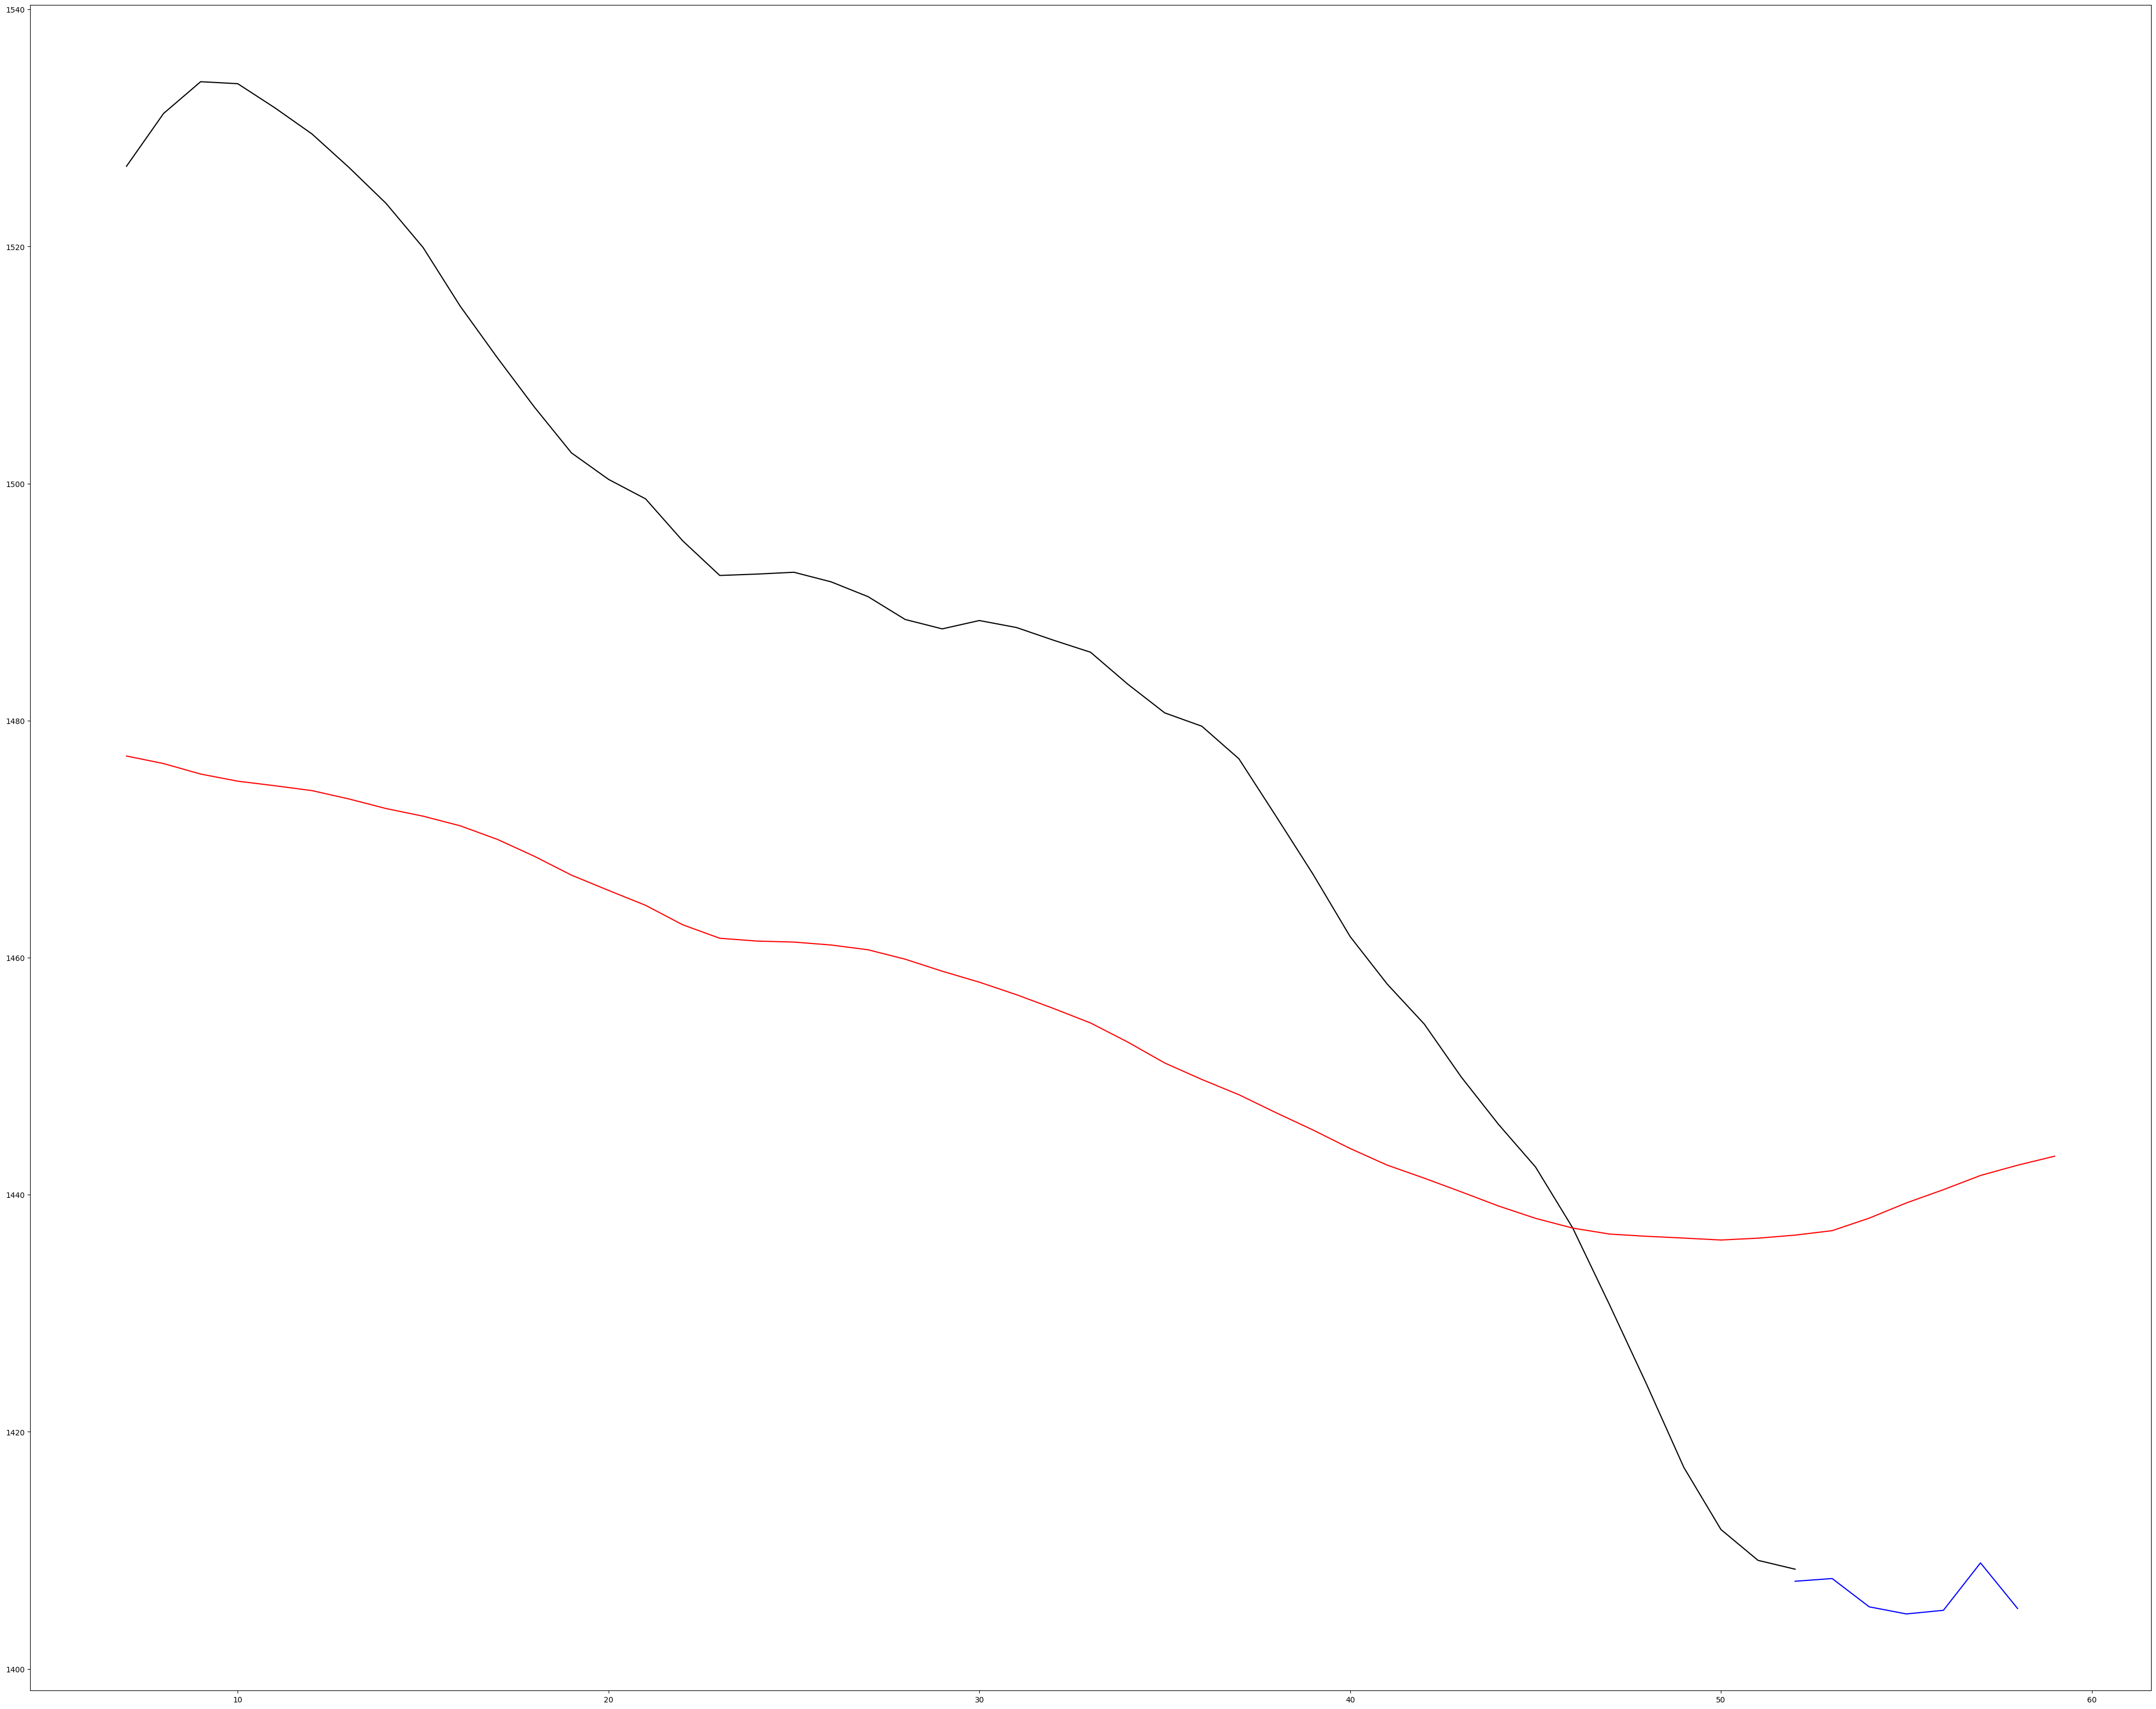

In [209]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))

plt.plot(data_backup.index[52:59], trend_predictions[0][0], color='blue')
plt.plot(data_backup.index[7:53], trends_test_dropna[0], color='black')
plt.plot(data_backup.index[7:60], trend_close_backup[:53], color='red')

In [49]:
trends_test_dropna.shape

(4966, 46)

In [75]:
trends_test_df = pd.DataFrame(trends_test_dropna, index=data_backup.index[output_step:-period])

In [76]:
trends_test_df

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
7,1526.767853,1531.222142,1533.902501,1533.733926,1531.700352,1529.499281,1526.666779,1523.636060,1519.907488,1514.962847,...,1449.918915,1445.940700,1442.338915,1437.213200,1430.686772,1423.976776,1416.992850,1411.756064,1409.153922,1408.407854
8,1531.222142,1533.902501,1533.733926,1531.700352,1529.499281,1526.666779,1523.636060,1519.907488,1514.962847,1510.618203,...,1445.940700,1442.338915,1437.213200,1430.686772,1423.976776,1416.992850,1411.756064,1409.153922,1408.407854,1409.571786
9,1533.902501,1533.733926,1531.700352,1529.499281,1526.666779,1523.636060,1519.907488,1514.962847,1510.618203,1506.452846,...,1442.338915,1437.213200,1430.686772,1423.976776,1416.992850,1411.756064,1409.153922,1408.407854,1409.571786,1411.856075
10,1533.733926,1531.700352,1529.499281,1526.666779,1523.636060,1519.907488,1514.962847,1510.618203,1506.452846,1502.586064,...,1437.213200,1430.686772,1423.976776,1416.992850,1411.756064,1409.153922,1408.407854,1409.571786,1411.856075,1413.928576
11,1531.700352,1529.499281,1526.666779,1523.636060,1519.907488,1514.962847,1510.618203,1506.452846,1502.586064,1500.352138,...,1430.686772,1423.976776,1416.992850,1411.756064,1409.153922,1408.407854,1409.571786,1411.856075,1413.928576,1417.937504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4968,14762.375070,14763.000767,14788.303606,14825.085031,14850.414307,14880.882882,14922.623954,14949.350377,14959.149658,14951.692487,...,15790.537807,15841.763846,15885.636335,15915.112758,15930.188477,15931.478132,15937.199219,15952.771380,15968.534633,15990.509661
4969,14763.000767,14788.303606,14825.085031,14850.414307,14880.882882,14922.623954,14949.350377,14959.149658,14951.692487,14943.211740,...,15841.763846,15885.636335,15915.112758,15930.188477,15931.478132,15937.199219,15952.771380,15968.534633,15990.509661,16025.567139
4970,14788.303606,14825.085031,14850.414307,14880.882882,14922.623954,14949.350377,14959.149658,14951.692487,14943.211740,14943.527448,...,15885.636335,15915.112758,15930.188477,15931.478132,15937.199219,15952.771380,15968.534633,15990.509661,16025.567139,16065.452846
4971,14825.085031,14850.414307,14880.882882,14922.623954,14949.350377,14959.149658,14951.692487,14943.211740,14943.527448,14930.242815,...,15915.112758,15930.188477,15931.478132,15937.199219,15952.771380,15968.534633,15990.509661,16025.567139,16065.452846,16108.927455


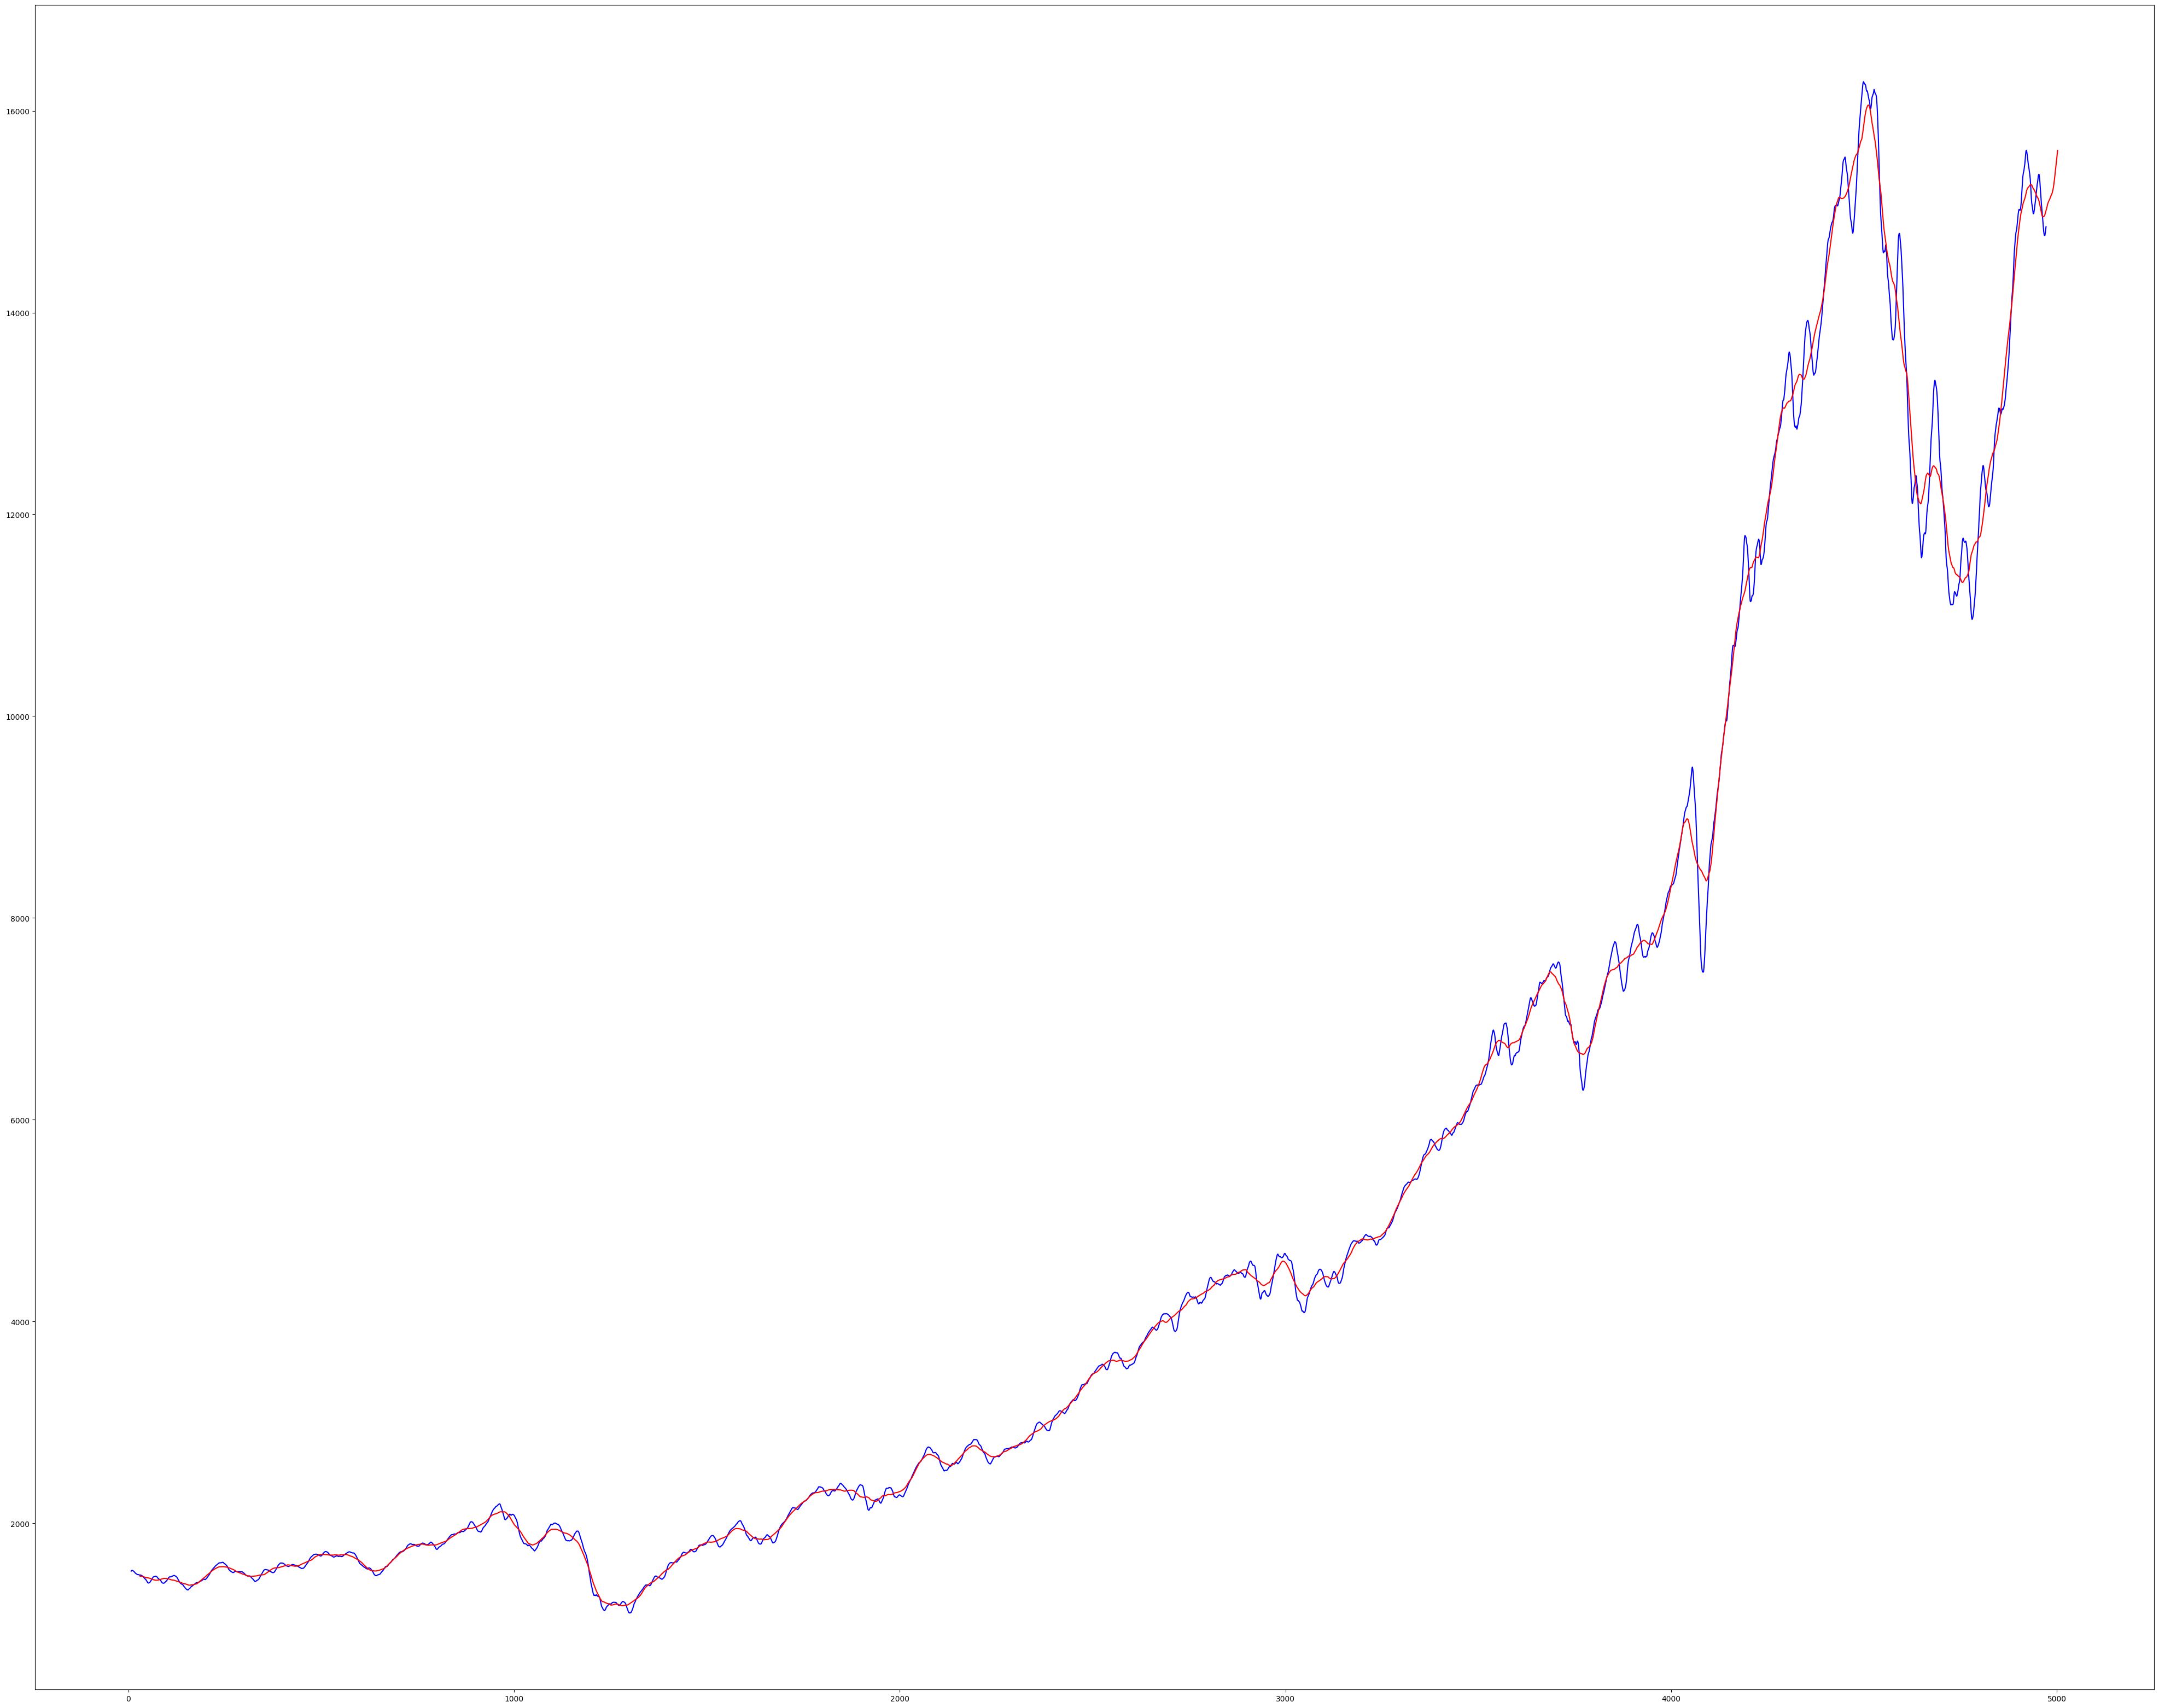

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))

plt.plot(trends_test_df[0], color='blue')
plt.plot(trend_close_backup, color='red')

In [85]:
input_period+output_step, period

(53, 60)

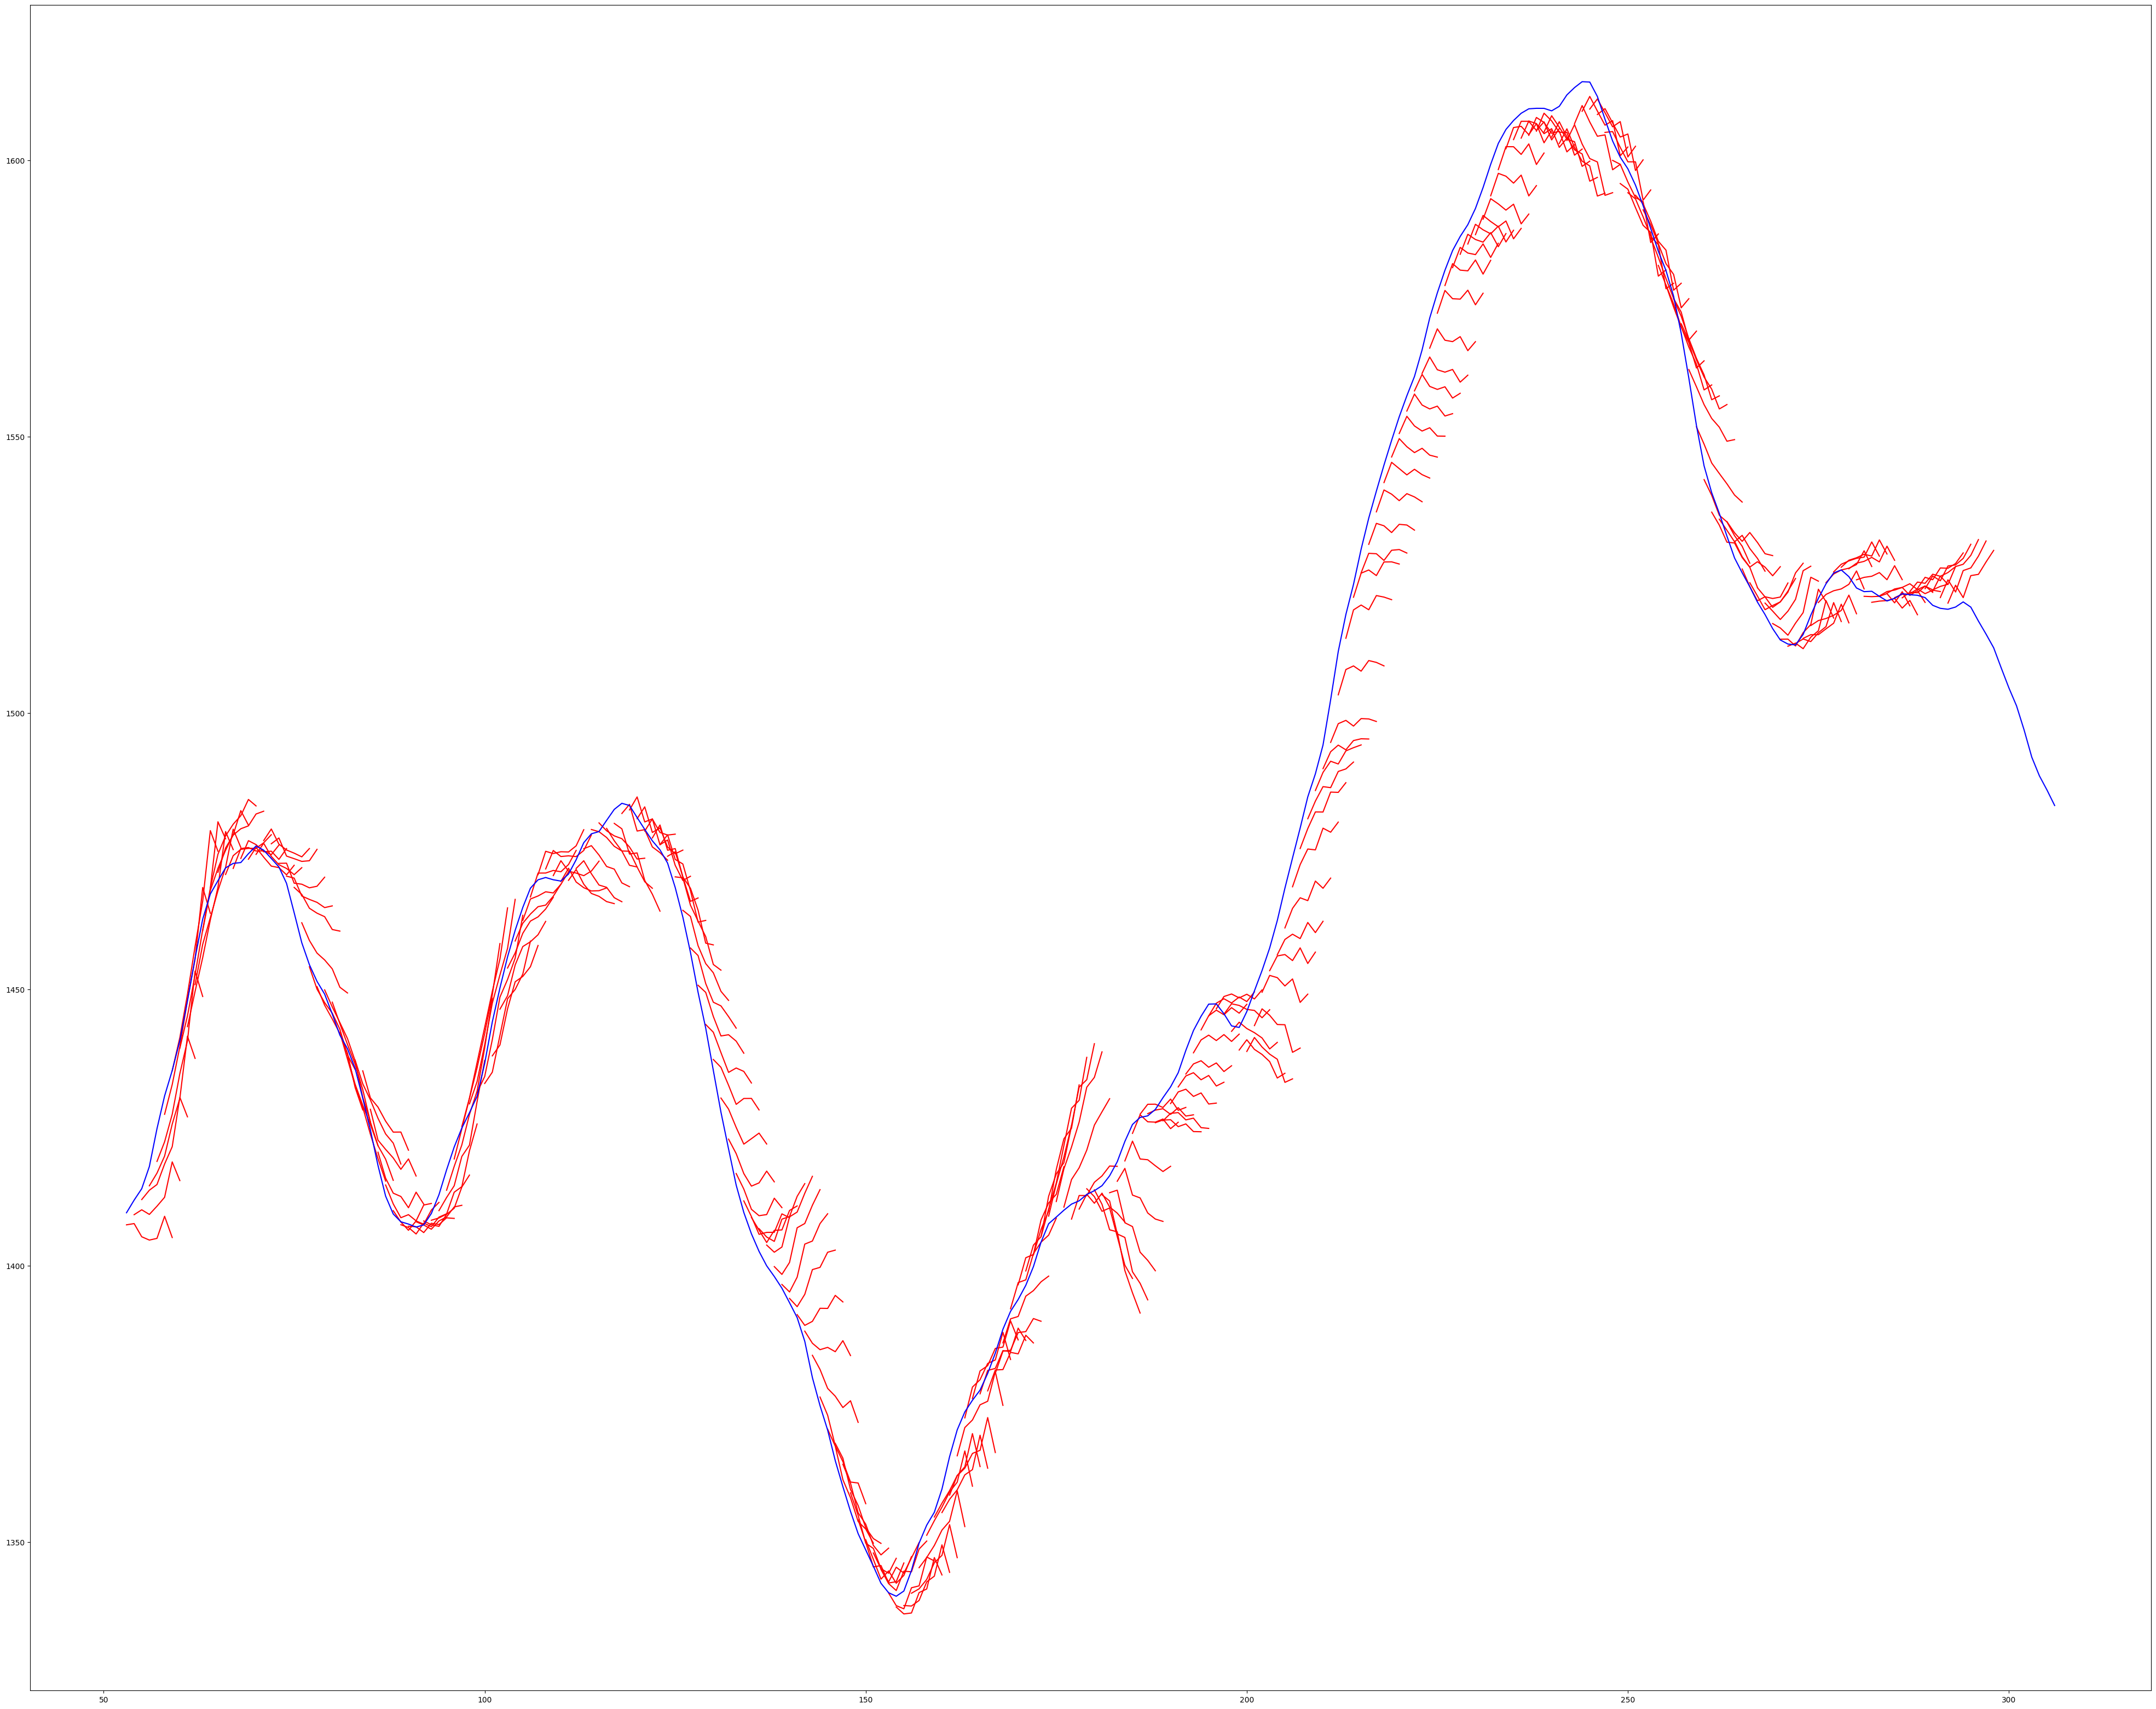

In [211]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))

for i in range(240):
    plt.plot(data_backup.index[i+(input_period+output_step):i+period], trend_predictions[i][0], color='red')

plt.plot(trends_test_df[0].iloc[46:300], color='blue')

In [90]:
trend_predictions[1][0][-1], trend_predictions.shape

(1415.3937, (4966, 1, 7))

In [106]:
trends_test_df.head(50)

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
7,1526.767853,1531.222142,1533.902501,1533.733926,1531.700352,1529.499281,1526.666779,1523.636060,1519.907488,1514.962847,...,1449.918915,1445.940700,1442.338915,1437.213200,1430.686772,1423.976776,1416.992850,1411.756064,1409.153922,1408.407854
8,1531.222142,1533.902501,1533.733926,1531.700352,1529.499281,1526.666779,1523.636060,1519.907488,1514.962847,1510.618203,...,1445.940700,1442.338915,1437.213200,1430.686772,1423.976776,1416.992850,1411.756064,1409.153922,1408.407854,1409.571786
9,1533.902501,1533.733926,1531.700352,1529.499281,1526.666779,1523.636060,1519.907488,1514.962847,1510.618203,1506.452846,...,1442.338915,1437.213200,1430.686772,1423.976776,1416.992850,1411.756064,1409.153922,1408.407854,1409.571786,1411.856075
10,1533.733926,1531.700352,1529.499281,1526.666779,1523.636060,1519.907488,1514.962847,1510.618203,1506.452846,1502.586064,...,1437.213200,1430.686772,1423.976776,1416.992850,1411.756064,1409.153922,1408.407854,1409.571786,1411.856075,1413.928576
11,1531.700352,1529.499281,1526.666779,1523.636060,1519.907488,1514.962847,1510.618203,1506.452846,1502.586064,1500.352138,...,1430.686772,1423.976776,1416.992850,1411.756064,1409.153922,1408.407854,1409.571786,1411.856075,1413.928576,1417.937504
12,1529.499281,1526.666779,1523.636060,1519.907488,1514.962847,1510.618203,1506.452846,1502.586064,1500.352138,1498.705353,...,1423.976776,1416.992850,1411.756064,1409.153922,1408.407854,1409.571786,1411.856075,1413.928576,1417.937504,1424.785008
13,1526.666779,1523.636060,1519.907488,1514.962847,1510.618203,1506.452846,1502.586064,1500.352138,1498.705353,1495.167494,...,1416.992850,1411.756064,1409.153922,1408.407854,1409.571786,1411.856075,1413.928576,1417.937504,1424.785008,1430.713222
14,1523.636060,1519.907488,1514.962847,1510.618203,1506.452846,1502.586064,1500.352138,1498.705353,1495.167494,1492.244276,...,1411.756064,1409.153922,1408.407854,1409.571786,1411.856075,1413.928576,1417.937504,1424.785008,1430.713222,1435.316075
15,1519.907488,1514.962847,1510.618203,1506.452846,1502.586064,1500.352138,1498.705353,1495.167494,1492.244276,1492.360705,...,1409.153922,1408.407854,1409.571786,1411.856075,1413.928576,1417.937504,1424.785008,1430.713222,1435.316075,1440.713218
16,1514.962847,1510.618203,1506.452846,1502.586064,1500.352138,1498.705353,1495.167494,1492.244276,1492.360705,1492.514993,...,1408.407854,1409.571786,1411.856075,1413.928576,1417.937504,1424.785008,1430.713222,1435.316075,1440.713218,1447.908578


In [215]:
observation_last_point = pd.Series([
    trend_predictions[i][0][-1] for i in range(trend_predictions.shape[0])
], index=trends_test_df.index)

In [216]:
observation_first_point = pd.Series([
    trend_predictions[i][0][0] for i in range(trend_predictions.shape[0])
], index=trends_test_df.index)

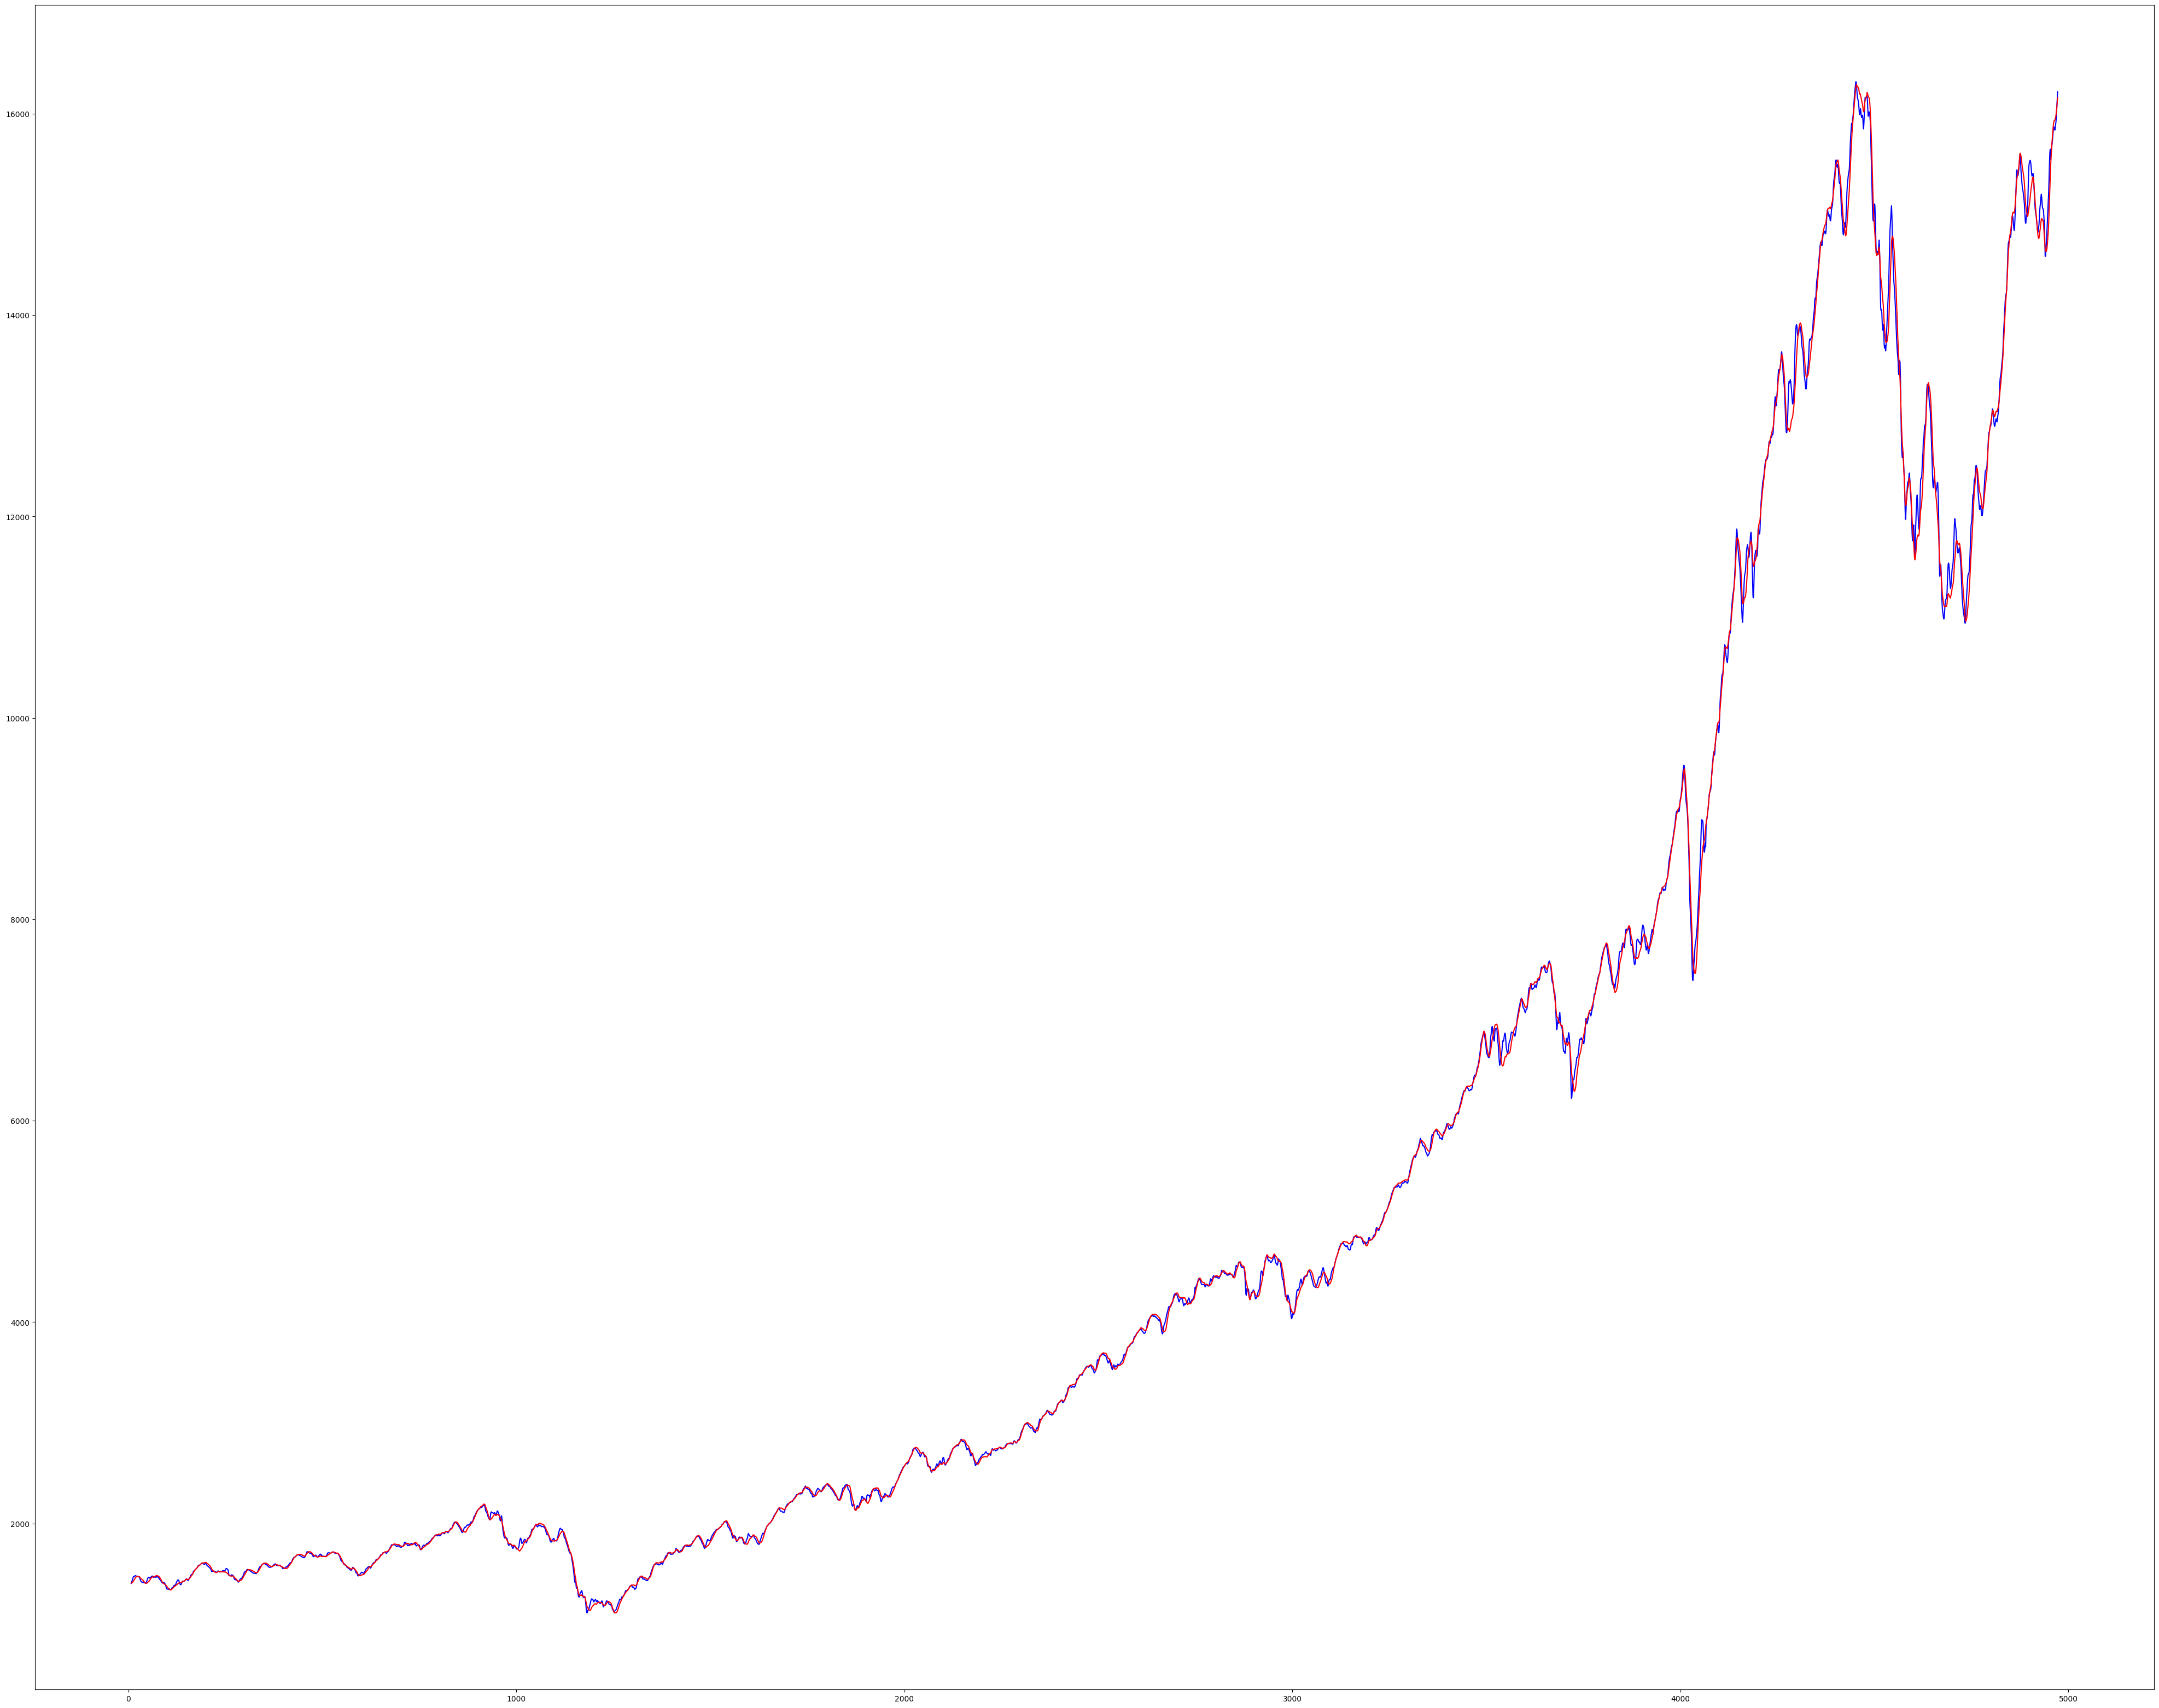

In [217]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))

plt.plot(observation_last_point, color='blue')
plt.plot(trends_test_df[45], color='red')

#### adding signal noise to the trend prediction:

In [218]:
noise_high, _ = create_dataset(data_backup[['high']].to_numpy(), time_step=period, output_step=output_step)
noise_low, _ = create_dataset(data_backup[['low']].to_numpy(), time_step=period, output_step=output_step)

In [219]:
noise_high, noise_high.shape

(array([[ 1479.58996582,  1496.57995605,  1504.4699707 , ...,
          1425.85998535,  1431.22998047,  1445.81994629],
        [ 1496.57995605,  1504.4699707 ,  1514.44995117, ...,
          1431.22998047,  1445.81994629,  1445.30004883],
        [ 1504.4699707 ,  1514.44995117,  1530.65002441, ...,
          1445.81994629,  1445.30004883,  1447.94995117],
        ...,
        [14849.25      , 14855.91992188, 14771.12011719, ...,
         16354.25      , 16581.0390625 , 16660.7109375 ],
        [14855.91992188, 14771.12011719, 14678.48046875, ...,
         16581.0390625 , 16660.7109375 , 16669.76953125],
        [14771.12011719, 14678.48046875, 14657.20996094, ...,
         16660.7109375 , 16669.76953125, 16764.3203125 ]]),
 (4966, 60))

In [220]:
std_dev_high = np.array([np.std(val) for val in noise_high])
std_dev_low = np.array([np.std(val) for val in noise_low])

In [221]:
std_dev_high, std_dev_high.shape

(array([ 45.30128454,  45.63915552,  45.92896816, ..., 611.62657837,
        630.38531013, 650.4241974 ]),
 (4966,))

In [222]:
std_dev_noise = np.array([np.maximum(val_high, val_low) for val_high, val_low in zip(std_dev_high, std_dev_low)])

In [229]:
induced_high_first_point = np.array([observation_first_point[i+7] + std_dev_noise[i] for i in range(std_dev_noise.shape[0])])
induced_low_first_point = np.array([observation_first_point[i+7] - std_dev_noise[i] for i in range(std_dev_noise.shape[0])])

induced_high_last_point = np.array([observation_last_point[i+7] + std_dev_noise[i] for i in range(std_dev_noise.shape[0])])
induced_low_last_point = np.array([observation_last_point[i+7] - std_dev_noise[i] for i in range(std_dev_noise.shape[0])])

induced_high_first_point = pd.Series(induced_high_first_point, index=data_backup.index[7:-60])
induced_low_first_point = pd.Series(induced_low_first_point, index=data_backup.index[7:-60])
induced_high_last_point = pd.Series(induced_high_last_point, index=data_backup.index[7:-60])
induced_low_last_point = pd.Series(induced_low_last_point, index=data_backup.index[7:-60])

In [230]:
data_output = data_backup.copy()

In [231]:
data_output['observation_first_point'] = observation_first_point
data_output['induced_high_first_point'] = induced_high_first_point
data_output['induced_low_first_point'] = induced_low_first_point
data_output['observation_first_point'] = data_output['observation_first_point'].shift(45)
data_output['induced_high_first_point'] = data_output['induced_high_first_point'].shift(45)
data_output['induced_low_first_point'] = data_output['induced_low_first_point'].shift(45)

data_output['observation_last_point'] = observation_last_point
data_output['induced_high_last_point'] = induced_high_last_point
data_output['induced_low_last_point'] = induced_low_last_point
data_output['observation_last_point'] = data_output['observation_last_point'].shift(45)
data_output['induced_high_last_point'] = data_output['induced_high_last_point'].shift(45)
data_output['induced_low_last_point'] = data_output['induced_low_last_point'].shift(45)

In [235]:
data_output.to_excel(f'pred_trend_lstm_m5-correction.xlsx')

In [232]:
data_output[50:60]

,date,open,high,low,close,volume,observation_first_point,induced_high_first_point,induced_low_first_point,observation_last_point,induced_high_last_point,induced_low_last_point
50,2004-03-16 00:00:00-05:00,1412.099976,1417.560059,1394.109985,1407.069946,1963640000,NaN,NaN,NaN,NaN,NaN,NaN
51,2004-03-17 00:00:00-05:00,1418.569946,1432.229980,1418.300049,1428.890015,1678770000,NaN,NaN,NaN,NaN,NaN,NaN
52,2004-03-18 00:00:00-05:00,1423.859985,1425.760010,1407.089966,1417.770020,1677760000,1407.390015,1452.691299,1362.088730,1405.093018,1450.394302,1359.791733
53,2004-03-19 00:00:00-05:00,1416.229980,1425.920044,1398.579956,1398.579956,1645680000,1409.225220,1454.864375,1363.586064,1415.393677,1461.032832,1369.754521
54,2004-03-22 00:00:00-05:00,1386.760010,1388.680054,1369.359985,1381.390015,1982240000,1411.963135,1457.892103,1366.034167,1426.927490,1472.856458,1380.998522
55,2004-03-23 00:00:00-05:00,1391.640015,1393.770020,1368.670044,1370.040039,1835180000,1414.457275,1460.501951,1368.412599,1437.501221,1483.545897,1391.456545
56,2004-03-24 00:00:00-05:00,1374.739990,1391.869995,1368.079956,1381.859985,1839440000,1418.860718,1464.772973,1372.948462,1448.695679,1494.607934,1402.783423
57,2004-03-25 00:00:00-05:00,1394.199951,1425.859985,1393.959961,1425.859985,1968620000,1427.386108,1473.033541,1381.738676,1463.755737,1509.403170,1418.108305
58,2004-03-26 00:00:00-05:00,1420.410034,1431.229980,1415.390015,1415.390015,1579820000,1435.265381,1480.373160,1390.157602,1474.974487,1520.082266,1429.866708
59,2004-03-29 00:00:00-05:00,1429.540039,1445.819946,1429.479980,1442.310059,1706000000,1439.336060,1483.898979,1394.773140,1477.227417,1521.790337,1432.664497


In [233]:
data_output.tail(50)

,date,open,high,low,close,volume,observation_first_point,induced_high_first_point,induced_low_first_point,observation_last_point,induced_high_last_point,induced_low_last_point
4983,2023-10-19 00:00:00-04:00,14981.129883,15023.910156,14749.299805,14783.129883,5014790000,14774.005859,15105.589850,14442.421869,14908.958984,15240.542975,14577.374994
4984,2023-10-20 00:00:00-04:00,14752.589844,14781.219727,14552.120117,14560.879883,4622840000,14694.529297,15032.430817,14356.627777,14756.122070,15094.023590,14418.220551
4985,2023-10-23 00:00:00-04:00,14514.110352,14746.370117,14419.059570,14604.849609,4669060000,14643.577148,14983.554243,14303.600054,14583.784180,14923.761274,14243.807086
4986,2023-10-24 00:00:00-04:00,14678.410156,14774.160156,14610.330078,14745.860352,4604720000,14634.208008,14972.941779,14295.474237,14583.488281,14922.222052,14244.754510
4987,2023-10-25 00:00:00-04:00,14642.080078,14643.690430,14362.240234,14381.639648,4599850000,14646.529297,14984.335612,14308.722982,14646.542969,14984.349284,14308.736654
4988,2023-10-26 00:00:00-04:00,14314.009766,14372.509766,14058.330078,14109.570312,4894900000,14656.273438,14994.871683,14317.675192,14715.807617,15054.405863,14377.209372
4989,2023-10-27 00:00:00-04:00,14245.750000,14321.040039,14130.370117,14180.419922,4172100000,14663.866211,15004.397476,14323.334945,14784.364258,15124.895523,14443.832992
4990,2023-10-30 00:00:00-04:00,14283.980469,14388.200195,14225.860352,14335.509766,4149320000,14685.332031,15028.571053,14342.093010,14867.768555,15211.007576,14524.529533
4991,2023-10-31 00:00:00-04:00,14340.860352,14420.440430,14232.400391,14409.780273,4315630000,14723.340820,15069.022483,14377.659157,14959.811523,15305.493186,14614.129861
4992,2023-11-01 00:00:00-04:00,14453.679688,14677.860352,14441.889648,14664.910156,4545120000,14781.518555,15129.992303,14433.044806,15055.164062,15403.637811,14706.690314


### manual testing:

In [390]:
import pandas as pd

data_manual = pd.read_csv('data/^NDX_raw_data.csv')
data_manual.rename(columns={'Date': 'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'}, inplace=True)

In [391]:
data_manual = data_manual[3577:3577+67]

In [392]:
data_manual

,date,open,high,low,close,volume
3577,2018-03-20 00:00:00-04:00,6871.089844,6902.229980,6845.850098,6885.919922,1976000000
3578,2018-03-21 00:00:00-04:00,6863.290039,6930.700195,6828.879883,6853.450195,1999230000
3579,2018-03-22 00:00:00-04:00,6763.939941,6809.939941,6679.350098,6682.259766,2370970000
3580,2018-03-23 00:00:00-04:00,6683.189941,6708.580078,6507.839844,6508.089844,2455760000
3581,2018-03-26 00:00:00-04:00,6644.399902,6760.649902,6538.790039,6753.830078,2341370000
...,...,...,...,...,...,...
3639,2018-06-18 00:00:00-04:00,7201.180176,7256.430176,7186.160156,7251.410156,2102660000
3640,2018-06-19 00:00:00-04:00,7158.799805,7229.990234,7138.020020,7228.040039,2283340000
3641,2018-06-20 00:00:00-04:00,7264.850098,7309.990234,7256.870117,7280.700195,2316420000
3642,2018-06-21 00:00:00-04:00,7304.049805,7308.259766,7203.930176,7217.490234,2349640000


In [393]:
X_manual = np.array(data_manual['close'][:60].to_numpy())

In [410]:
data_manual[:60]

,date,open,high,low,close,volume,observation,induced_high,induced_low
3577,2018-03-20 00:00:00-04:00,6871.089844,6902.229980,6845.850098,6885.919922,1976000000,0.000000,0.000000,0.000000
3578,2018-03-21 00:00:00-04:00,6863.290039,6930.700195,6828.879883,6853.450195,1999230000,0.000000,0.000000,0.000000
3579,2018-03-22 00:00:00-04:00,6763.939941,6809.939941,6679.350098,6682.259766,2370970000,0.000000,0.000000,0.000000
3580,2018-03-23 00:00:00-04:00,6683.189941,6708.580078,6507.839844,6508.089844,2455760000,0.000000,0.000000,0.000000
3581,2018-03-26 00:00:00-04:00,6644.399902,6760.649902,6538.790039,6753.830078,2341370000,0.000000,0.000000,0.000000
3582,2018-03-27 00:00:00-04:00,6791.390137,6793.500000,6479.560059,6529.839844,2347480000,0.000000,0.000000,0.000000
3583,2018-03-28 00:00:00-04:00,6488.020020,6559.879883,6410.040039,6460.810059,2551950000,0.000000,0.000000,0.000000
3584,2018-03-29 00:00:00-04:00,6493.509766,6640.759766,6435.669922,6581.129883,2593390000,0.000000,0.000000,0.000000
3585,2018-04-02 00:00:00-04:00,6528.229980,6560.959961,6322.600098,6390.839844,2402670000,0.000000,0.000000,0.000000
3586,2018-04-03 00:00:00-04:00,6448.049805,6485.270020,6343.899902,6458.830078,2330900000,0.000000,0.000000,0.000000


In [394]:
X_manual, X_manual.shape

(array([6885.91992188, 6853.45019531, 6682.25976562, 6508.08984375,
        6753.83007812, 6529.83984375, 6460.81005859, 6581.12988281,
        6390.83984375, 6458.83007812, 6560.06005859, 6594.83984375,
        6433.20996094, 6472.33984375, 6615.87011719, 6583.43994141,
        6656.25976562, 6628.33984375, 6675.18017578, 6816.37011719,
        6833.20996094, 6774.89013672, 6667.75      , 6648.79980469,
        6509.04980469, 6513.93994141, 6649.64990234, 6656.35009766,
        6605.56982422, 6681.95996094, 6644.47998047, 6643.47998047,
        6769.12011719, 6821.87011719, 6815.47998047, 6893.20996094,
        6963.54980469, 6952.56005859, 6964.37011719, 6888.54003906,
        6929.97021484, 6901.62988281, 6866.25      , 6905.52978516,
        6893.62011719, 6953.62988281, 6949.70019531, 6960.91992188,
        6926.54003906, 6976.37011719, 6967.72998047, 7083.93017578,
        7143.56982422, 7166.75      , 7210.08007812, 7152.83007812,
        7152.62011719, 7168.47998047, 7209.18017

In [395]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_manual = seasonal_decompose(X_manual, model='additive', period=14)
trend_manual = decomposition_manual.trend

In [396]:
trend_manual

array([          nan,           nan,           nan,           nan,
                 nan,           nan,           nan, 6573.60173689,
       6554.31387765, 6543.74208287, 6547.1081543 , 6548.59387207,
       6556.01817104, 6579.5513916 , 6599.77139718, 6616.58105469,
       6633.25533622, 6638.21817453, 6633.50709752, 6638.3478132 ,
       6652.64960589, 6658.85353306, 6662.00423758, 6665.1021031 ,
       6665.22211565, 6669.11783273, 6672.66925921, 6672.23247419,
       6675.82496861, 6690.61495536, 6712.02781459, 6739.13783482,
       6768.77784947, 6792.16786412, 6810.93929618, 6829.00929478,
       6846.30393764, 6863.18643624, 6883.1610805 , 6900.68715123,
       6912.10250419, 6921.0349993 , 6927.97143555, 6931.09073312,
       6935.93181501, 6947.02359445, 6963.35965402, 6983.29964774,
       7002.27500698, 7021.47394671, 7041.0925293 , 7061.75360979,
       7082.01039342,           nan,           nan,           nan,
                 nan,           nan,           nan,           

In [397]:
trend_manual = trend_manual[~np.isnan(trend_manual)]

In [398]:
trend_manual.shape

(46,)

In [399]:
from sklearn.preprocessing import MinMaxScaler

scaler_manual = MinMaxScaler()
data_manual_scaled = scaler_manual.fit_transform(trend_manual.reshape(-1,1))

In [400]:
data_manual_scaled.shape

(46, 1)

In [401]:
pred_manual = model.predict(data_manual_scaled.reshape(data_manual_scaled.shape[1], input_period, 1))
pred_manual = scaler_manual.inverse_transform(pred_manual)

1/1 [==============================] - 0s 51ms/step


In [402]:
pred_manual[0][-1]

7121.089

In [403]:
noise_high_manual = data_manual[['high']][:60].to_numpy()
noise_low_manual = data_manual[['low']][:60].to_numpy()

In [404]:
std_dev_high_manual = np.std(noise_high_manual)
std_dev_low_manual = np.std(noise_low_manual)

std_dev_noise_manual = np.maximum(std_dev_high_manual, std_dev_low_manual)

In [405]:
data_manual['observation'] = 0.
data_manual['induced_high'] = 0.
data_manual['induced_low'] = 0.

for i in range(pred_manual.shape[1]):
    data_manual.loc[data_manual.index[0]+53+i, 'observation'] = pred_manual[0][i]
    data_manual.loc[data_manual.index[0]+53+i, 'induced_high'] = pred_manual[0][i] + std_dev_noise_manual
    data_manual.loc[data_manual.index[0]+53+i, 'induced_low'] = pred_manual[0][i] - std_dev_noise_manual

In [406]:
pred_manual.shape

(1, 7)

In [407]:
data_manual[50:70]

,date,open,high,low,close,volume,observation,induced_high,induced_low
3627,2018-05-31 00:00:00-04:00,6969.930176,7016.419922,6955.990234,6967.729980,2533360000,0.000000,0.000000,0.000000
3628,2018-06-01 00:00:00-04:00,7010.080078,7084.839844,7008.020020,7083.930176,2212330000,0.000000,0.000000,0.000000
3629,2018-06-04 00:00:00-04:00,7099.500000,7146.770020,7099.089844,7143.569824,2152170000,0.000000,0.000000,0.000000
3630,2018-06-05 00:00:00-04:00,7162.410156,7179.819824,7137.129883,7166.750000,2063270000,7085.566406,7321.358464,6849.774348
3631,2018-06-06 00:00:00-04:00,7180.240234,7212.450195,7140.919922,7210.080078,2198100000,7100.665527,7336.457585,6864.873469
3632,2018-06-07 00:00:00-04:00,7212.430176,7212.430176,7115.859863,7152.830078,2339720000,7107.416016,7343.208074,6871.623958
3633,2018-06-08 00:00:00-04:00,7121.759766,7161.919922,7100.729980,7152.620117,1949810000,7106.019043,7341.811101,6870.226985
3634,2018-06-11 00:00:00-04:00,7149.649902,7187.450195,7146.089844,7168.479980,1959360000,7116.947754,7352.739812,6881.155696
3635,2018-06-12 00:00:00-04:00,7181.669922,7214.490234,7173.759766,7209.180176,2019890000,7113.173340,7348.965398,6877.381282
3636,2018-06-13 00:00:00-04:00,7219.580078,7261.169922,7193.020020,7205.259766,2197830000,7121.088867,7356.880925,6885.296809


In [339]:
data_manual.iloc[53]

date                        2018-06-05 00:00:00-04:00
open                                      7162.410156
high                                      7179.819824
low                                       7137.129883
close                                         7166.75
volume                                     2063270000
observation_first_point                   7085.566406
induced_high_first_point                  7321.358464
induced_low_first_point                   6849.774348
observation_last_point                    7121.088867
induced_high_last_point                   7356.880925
induced_low_last_point                    6885.296809
Name: 3630, dtype: object

In [409]:
data_manual.to_excel(f'pred_trend_lstm_m5-manual.xlsx')